# Luminosity Calculation, Average Flux/Luminosity SED
### Version 2022

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uncertainties as uncer
import uncertainties.umath as umath
from astropy import units as u
from scipy.optimize import curve_fit
%matplotlib widget

def ClearData():
    data = {
    'Name': [],
    'RA': [],
    'DEC': [],
    'z': [], 
    'class_name': [],
    'alpha': [],
    'xxK': [],
    'yyK': [],
    'yyerrK': [],
    'radio_nuLnu0': [],
    'radio_nuLnu0_err': [],
    'alphaIRO': [],
    'xxIROK': [],
    'yyIROK': [],
    'yyerrIROK': [],
    'IRO_nuLnu0': [],
    'IRO_nuLnu0_err': [] 
    }
    return data


In [ ]:
#######################################################################################################
### save frequency, flux, spectral index*4 into a file
#######################################################################################################
Xmatch = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/data/BZCAT_Xmatch_ACC_csv.csv') # # = 37671
df = ClearData()

#for i in range(0, 1): # 1367
for i, Dataname in enumerate( list(set(Xmatch.name)) ):  
    # specify index in [], to start on certain sources ("if kernal stopped acciently")
    # if kernal have been restart, specify certain in [] will not start on the index which stopped
    
    plotfigure = 0
    
    VPath = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/VLASS match'
    Vdata = pd.read_csv(VPath + '/' + Dataname + '.csv') 
    
    GPath = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/GLEAM match'
    Gdata = pd.read_csv(GPath + '/' + Dataname + '.csv') 
    
    SPath = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/SDSS match'
    Sdata = pd.read_csv(SPath + '/' + Dataname + '.csv') 
    
    WPath = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/WISE match'
    Wdata = pd.read_csv(WPath + '/' + Dataname + '.csv')
    
    FPath = '/Users/87steven/Documents/ASIAA/Blazar SED code and data/FIRST match'
    Fdata = pd.read_csv(FPath + '/' + Dataname + '.csv')
    
    print('i = ', i, ', V source name = ', Dataname)
    #######################################################################################################
    ### extract flux density or magnitude 
    ## BZCAT
    Name = Vdata.Name[0] #Xmatch data
    RA = Vdata.RA[0]
    DEC = Vdata.DEC[0]
    z = Vdata.z[0]
    cla = Vdata['class'][0]
    flux_ratio = Vdata['flux_ratio'].values[0]        # flux ratio of 1.4/0.843 GHz 
    flux_143 = Vdata['flux_143'].values[0]            # 143 GHz [mJy]
    flux_xray = Vdata['flux_xray'].values[0]          # x-ray flux 0.1-2.4 keV [fW/m^2]; f = 10E-15
                                                      # F(lambda) = [W/m^2/(wavelength)]
                                                      # => [fW/m^2] = lambda*F(lambda) = nu*F(nu)
    flux_gamma = Vdata['flux_gamma'].values[0]        # fermi flux 1-100 GeV [ph/cm^2/s]
                                                      # 1 Jy = 1.51E7 ph/s/m^2 = 1.51E3 ph/s/cm^2
    Spec_index = Vdata.Spec_index[0]                  # radio-optical spectral index
    ### ACC
    flux_ALMA = Vdata['flux_ALMA'].values             # flux density [Jy]
    errflux = Vdata['errflux'].values                 # error of flux density [Jy]
    band = Vdata['band'].values  
    freq = Vdata['freq'].values                       # frequency [GHz]
    date = Vdata['date'].values   
    ### VLASS data   
    V_Fint = Vdata['Ftot'].values                    # integrated flux from 2-4 GHz [mJy]
    V_eFint = Vdata['eFtot'].values                       # error of total flux [mJy]
    V_Fp = Vdata['Fpeak'].values                     # peak flux from 2-4 GHz [mJy/beam]
    V_eFp = Vdata['eFpeak'].values                   # error of peak flux [mJy/beam]
    ### GLEAM data
    Fpwide = Gdata['Fpwide'].values                   # peak flux from 170-231 MHz [Jy/beam]
    e_Fpwide = Gdata['e_Fpwide'].values               # error of peak flux from 170-231 MHz [Jy/beam]
    Fintwide = Gdata['Fintwide'].values               # integrated flux from 170-231 MHz [Jy]
    e_Fintwide = Gdata['e_Fintwide'].values           # error of integrated flux from 170-231 MHz [Jy]
    # for all data below number of each value name is the centralfrequency of the measurement
    # frequency ranging from number of each value name +-4 [MHz]
    # eg., Fp076 => Frequecny from 76-4 ~ 76+4 = 72~80 MHz
    # eg., Fp084 => Frequecny from 84-4 ~ 84+4 = 80~88 MHz
    GFp = [None] * 20
    eGFp = [None] * 20
    GFint = [None] * 20
    eGFint = [None] * 20
    GFpname = ['Fp076', 'Fp084', 'Fp092', 'Fp099', 'Fp107', 'Fp115', 'Fp122', 'Fp130', 'Fp143', 'Fp151', 'Fp158', 'Fp166',
                'Fp174', 'Fp181', 'Fp189', 'Fp197', 'Fp204', 'Fp212', 'Fp220', 'Fp227']
    eGFpname = ['e_Fp076', 'e_Fp084', 'e_Fp092', 'e_Fp099', 'e_Fp107', 'e_Fp115', 'e_Fp122', 'e_Fp130', 'e_Fp143', 'e_Fp151', 
                'e_Fp158', 'e_Fp166', 'e_Fp174', 'e_Fp181', 'e_Fp189', 'e_Fp197', 'e_Fp204', 'e_Fp212', 'e_Fp220', 'e_Fp227']
    GFintname = ['Fint076', 'Fint084', 'Fint092', 'Fint099', 'Fint107', 'Fint115', 'Fint122', 'Fint130', 'Fint143', 'Fint151',
                 'Fint158', 'Fint166', 'Fint174', 'Fint181', 'Fint189', 'Fint197', 'Fint204', 'Fint212', 'Fint220', 'Fint227']
    eGFintname = ['e_Fint076', 'e_Fint084', 'e_Fint092', 'e_Fint099', 'e_Fint107', 'e_Fint115', 'e_Fint122', 'e_Fint130',  
                  'e_Fint143', 'e_Fint151', 'e_Fint158', 'e_Fint166', 'e_Fint174', 'e_Fint181', 'e_Fint189', 'e_Fint197', 
                  'e_Fint204', 'e_Fint212', 'e_Fint220', 'e_Fint227']

    for i in range(0, len(GFp)):
        GFp[i] = Gdata[GFpname[i]].values[ np.logical_not(np.isnan(Gdata[GFpname[i]].values)) ]
            # peak flux from 72-80 MHz [Jy/beam]
        eGFp[i] = Gdata[eGFpname[i]].values[ np.logical_not(np.isnan(Gdata[eGFpname[i]].values)) ]
            # rms uncertainty in fit for or peak flux in 072-080MHz [Jy/beam]
        GFint[i] = Gdata[GFintname[i]].values[ np.logical_not(np.isnan(Gdata[GFintname[i]].values)) ]
            # Integrated flux in 072-080MHz [Jy]
        eGFint[i] = Gdata[eGFintname[i]].values[ np.logical_not(np.isnan(Gdata[eGFintname[i]].values)) ]
            # rms uncertainty in fit for integrated flux in 072-80 MHz [Jy/beam] 
            
    ### SDSS data
    Smag = [None]*5
    eSmag = [None]*5
    Smagname = ['umag','gmag','rmag','imag','zmag']
    eSmagname = ['eumag','egmag','ermag','eimag','ezmag']
    for i in range(0, len(Smag)):
        Smag[i] = Sdata[Smagname[i]].values[ np.logical_not(np.isnan(Sdata[Smagname[i]].values)) ]
        eSmag[i] = Sdata[eSmagname[i]].values[ np.logical_not(np.isnan(Sdata[eSmagname[i]].values)) ]
                    
    ### WISE data
    Wmag = [None]*7
    eWmag = [None]*7
    Wmagname = ['W1mag','W2mag','W3mag','W4mag','Jmag','Hmag','Kmag']
    eWmagname = ['eW1mag','eW2mag','eW3mag','eW4mag','eJmag','eHmag','eKmag']
    for i in range(0, len(Wmag)):
        Wmag[i] = Wdata[Wmagname[i]].values
        eWmag[i] = Wdata[eWmagname[i]].values
        
    ### FIRST
    F_Fp= Fdata['Fpeak'].values                  # peak flux between 0.75-1.5 GHz [mJy] (750-1500 MHz)
    F_Fint = Fdata['Fint'].values                # integrated flux between 0.75-1.5 GHz [mJy]
    F_eFp = Fdata['rms_error'].values            # error of flux density [mJy]
    
    #######################################################################################################
    # set Jy2erg = 10E-23 =====> convert Jy to erg/s/cm^2
    # set Jy2erg = 1 =====> display SED flux density in the unit of "Jy"
    Jy2erg = 10E-23
    #######################################################################################################
    ### put peak flux and observed frequency into an array
    # BZCAT
    BZradio = [143E9, flux_143/1000*143E9*Jy2erg]
    BZxray = [3E17, flux_xray*1E-15]
    BZgamma = [1.3E25, flux_gamma*1.22E25/1.51E3*Jy2erg]  # 1 -100 GeV => median 50.5 GeV ~1.22*10^25 Hz
    # ACC
    ACCcom = [freq*1E9, flux_ALMA*freq*1E9*Jy2erg]
    # VLASS
    Vpeak = [np.linspace(3E9, 3E9, num = len(V_Fp)), V_Fp*3E9/1000*Jy2erg]  
    # GLEAM peak flux
    GFpdata = [None] * 20 
    for i in range(0, len(GFp)):
        Gfreq = float(GFpname[i][2::])*1E6 # MHz
        GFpdata[i] = [np.linspace(Gfreq, Gfreq, num = len(GFp[i])), GFp[i]*Gfreq*Jy2erg]
    # SDSS magnitude to AB magnitude to flux density 
    Sdata = [None]*5
    Sabmag = [None]*5
    eSabmag = [None]*5
    Sflux = [None]*5
    eSflux = [None]*5
    b = [1.4E-10, 0.9E-10, 1.2E-10, 1.8E-10, 7.4E-10]
    Sfreq = [8.44E14, 6.40E14, 4.87E14, 4.01E14, 3.36E14]
    ABcorr = [-0.04, 0, 0, 0, 0.02]
    for i in range(0, len(Sdata)):
        for j in range(0, 5):
            if i == j:
                Sabmag[j] = Smag[j]+ABcorr[j] 
                eSabmag[j] = eSmag[j]+ABcorr[j] 
            
        Sflux[i] = 10**((8.9-Sabmag[i])/2.5) 
        eSflux[i] = 10**((8.9- (Sabmag[i]+eSabmag[i])) /2.5)
        Sdata[i] = [np.linspace(Sfreq[i], Sfreq[i], num = len(Sflux[i])), Sflux[i]*Sfreq[i]*Jy2erg]   
    if len(Sdata[0][0]) == 0:
        for i in range(0, 5):
            Sdata[i] = [np.linspace(Sfreq[i], Sfreq[i], num = 2), np.array([np.nan, np.nan])]
    # WISE magnitude to AB magnitude to flux density 
    Wdata = [None]*7
    Wabmag = [None]*7
    eWabmag = [None]*7
    Wflux = [None]*7
    eWflux = [None]*7
    Wfreq = [8.95E13, 6.72E13, 2.59E13, 1.36E13, 2.43E14, 1.78E14, 1.39E14]
    ABcorr = [2.699, 3.339, 5.174, 6.620, 0.91, 1.39, 1.85]
    for i in range(0, len(Wdata)):
        for j in range(0, 7):
            if i == j:
                Wabmag[j] = Wmag[j]+ABcorr[j]
                eWabmag[j] = eWmag[j]+ABcorr[j]
            
        Wflux[i] = 10**((8.9-Wabmag[i])/2.5)
        eWflux[i] = 10**( (8.9-(Wabmag[i]+eWabmag[i]))/2.5)
        Wdata[i] = [np.linspace(Wfreq[i], Wfreq[i], num = len(Wflux[i])), Wflux[i]*Wfreq[i]*Jy2erg]   
    # FIRST
    Fpeak = [np.linspace(1.125E9, 1.125E9, num = len(F_Fp)), F_Fp*1.125E9/1000*Jy2erg]
    #######################################################################################################
    ### put uncertainty of each data point in to an array
    # BZCAT peak flux uncertainty
    e_freq_gamma = 0.434*(1.1E25/1.3E25)
    e_freq_xray = 0.434*(2.8E17/3.0E17)
    # ACC peak flux uncertainty
    e_ACC = [0.434*( (errflux*freq*1.0E9*Jy2erg)/(flux_ALMA*freq*1.0E9*Jy2erg) )]
    # VLASS observing frequency and peak flux uncertainty
    e_freq_VLASS = np.array(0.434*(1.0E9/3.0E9)) # frequency error
    e_Vpeak = [0.434*(V_eFp*Jy2erg/(V_Fp*Jy2erg))] # peak flux error
    # GLEAM observing frequency and peak flux uncertainty 
    eGFp_freq = [None]*20 
    eGFpdata = [None]*20
    for i in range(0, len(eGFpdata)):
        eGFp_freq[i] = np.array(0.434*(4/float(GFpname[i][2::]))) # freq error
        eGFpdata[i] = 0.434*(eGFp[i]*Jy2erg/(GFp[i]*Jy2erg)) # peak flux error
    # SDSS observing frequency and peak flux uncertainty 
    eS_freq = [None]*5
    eSdata = [None]*5
    maxfreq = [9.84E14, 7.93E14, 5.54E14, 4.48E14, 3.37E14]
    minfreq = [7.45E14, 5.41E14, 4.29E14, 3.58E14, 2.77E14]
    if ~np.isnan(Sdata[0][1][0]):
        for i in range(0, len(eSdata)):
            low_err = [ 0.434*( (Sfreq[i]-minfreq[i])/Sfreq[i] ) ]
            up_err = [ 0.434*( (maxfreq[i]-Sfreq[i])/Sfreq[i] ) ]
            eS_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T
            eSdata[i] = 0.434*((eSflux[i]*Sfreq[i]*Jy2erg-Sdata[i][1])/Sdata[i][1])
    else:
        for i in range(0, len(eSdata)):
            eSdata[i] = np.array([np.nan, np.nan])
    # WISE observing frequency and peak flux uncertainty 
    eW_freq = [None]*7
    eWdata = [None]*7
    maxfreq = [1.09E14, 7.57E13, 4.03E13, 1.54E13, 2.75E14, 2.06E14, 1.55E14]
    minfreq = [7.75E13, 5.62E13, 1.74E13, 1.07E13, 2.11E14, 1.50E14, 1.23E14]
    for i in range(0, len(eWdata)):
        low_err = [ 0.434*( (Wfreq[i]-minfreq[i])/Wfreq[i] ) ]
        up_err = [ 0.434*( (maxfreq[i]-Wfreq[i])/Wfreq[i] ) ]
        eW_freq[i] = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T        
        eWdata[i] = 0.434*((eWflux[i]*Wfreq[i]*Jy2erg-Wdata[i][1])/Wdata[i][1])   
    # FIRST observing frequency and peak flux uncertainty
    e_freq_FIRST = np.array(0.434*(0.375E9/1.125E9)) # frequency error
    e_Fpeak = [0.434*(F_eFp*Jy2erg/(F_Fp*Jy2erg))] # peak flux error
    #######################################################################################################
    ### data arrange
    nGFpdata = [item for sublist in GFpdata for item in sublist]
    nGFpfreq = []
    nGFpflux = []
    for i in range(0, int(len(GFpdata))):
        nGFpfreq.append(nGFpdata[2*i])
        nGFpflux.append(nGFpdata[2*i+1])
    
    nGFpfreq = np.array([item for sublist in nGFpfreq for item in sublist])
    nGFpflux = np.array([item for sublist in nGFpflux for item in sublist])
        
    nWfreq = [None]*7
    nWflux = [None]*7
    neWdata = [None]*7
    for i in range(0, 7): 
        nWfreq[i] = Wdata[i][0][0]
        nWflux[i] = Wdata[i][1][0]
        neWdata[i] = eWdata[i][0]
        
    nSfreq = [None]*5
    nSflux = [None]*5
    neSdata = [None]*5
    for i in range(0, 5):
        nSfreq[i] = Sdata[i][0][0]
        nSflux[i] = Sdata[i][1][0]
        neSdata[i] = eSdata[i][0]
            
    ne_ACC = [item for sublist in e_ACC for item in sublist]
    ne_Vpeak = [item for sublist in e_Vpeak for item in sublist]
    neGFp = [item for sublist in eGFpdata for item in sublist]
    ne_Fpeak = [item for sublist in e_Fpeak for item in sublist]
    
    #######################################################################################################
    ### spectral index fitting and luminosity calculation
    #######################################################################################################
    
    if z != 0:
        ### spectral index fitting (radio to sub-mm/mm)
        # frequency data combination (BZCAT_radio, ACC, VLASS, GLEAM, FIRST)
        allfreq = []
        allfreq = np.hstack([BZradio[0], ACCcom[0][0::], Vpeak[0][0], nGFpfreq, Fpeak[0][0] ])
        allfreq = np.log10(allfreq)
        # flux density combination
        allflux = []
        allflux = np.hstack([BZradio[1], ACCcom[1][0::], np.nansum(Vpeak[1][0::]), nGFpflux, np.nansum(Fpeak[1][0::])  ])
        allflux = np.log10(allflux)
        # flux density uncertainty combnation
        allfluxerr = []
        allfluxerr = np.hstack([np.nan, ne_ACC, ne_Vpeak[0], neGFp, ne_Fpeak[0]]) # np.nan is error for BZCAT radio data
        # find nan and infinity index of conbined frequency, flux density, and flux density uncertainty
        data_ind = []
        data_ind = np.hstack([ np.where( np.isnan(allfreq) )[0].flatten(), np.where( np.isnan(allflux))[0].flatten(), 
                               np.where( np.isinf(allfreq) )[0].flatten(), np.where( np.isinf(allflux) )[0].flatten(), 
                               np.where( np.isnan(allfluxerr) )[0].flatten(), np.where( np.isinf(allfluxerr))[0].flatten() ]) 
    
        xx = np.delete(allfreq, data_ind)
        yy = np.delete(allflux, data_ind)
        yy_err = np.delete(allfluxerr, data_ind)
    
        # define fitting function
        def func(x, a, c):
            return x**(a)+c
        
        if len(xx) >= 2:
            p0 = [min(xx), min(yy)]
            popt, pcov = curve_fit(func, xx, yy, p0 = p0) # p0 is initial point
            yfit = func(xx, *popt)
    
        alpha = '%7.5f' % float(popt[0])
    
        ### K-correction
        allfreq = np.hstack([BZradio[0], ACCcom[0][0::], Vpeak[0][0], nGFpfreq, Fpeak[0][0] ])
        allflux = np.hstack([BZradio[1], ACCcom[1][0::], np.nansum(Vpeak[1][0::]), nGFpflux, np.nansum(Fpeak[1][0::]) ])
        allfluxerr = np.hstack([np.nan, ne_ACC, ne_Vpeak[0], neGFp, ne_Fpeak[0]]) # np.nan is error for BZCAT radio data
        
        allfreq = np.delete(allfreq, data_ind)
        allflux = np.delete(allflux, data_ind)
        allfluxerr = np.delete(allfluxerr, data_ind)
        
        xxK = np.log10( allfreq*(1+z) )
        yyK = np.log10( allflux*(1+z)**(float(alpha)+1) )
        yyerrK = np.log10(allfluxerr*(1+z)**(float(alpha)+1))
        
        ### calculate radio luminosity
        c = 3.0E8 # [m/s]
        H0 = 2.0E-17 # [m/s/m] (H_0 = 69 km/s/Mpc)
        
        allfreq = np.hstack([BZradio[0], ACCcom[0][0::], Vpeak[0][0], nGFpfreq, Fpeak[0][0] ])
        allfreq[allfreq == 0] = np.nan
        allflux = np.hstack([BZradio[1], ACCcom[1][0::], np.nansum(Vpeak[1][0::]), nGFpflux, np.nansum(Fpeak[1][0::]) ])
        allflux[allflux == 0] = np.nan
        allfluxerr = np.hstack([np.nan, ne_ACC, ne_Vpeak[0], neGFp, ne_Fpeak[0]]) # np.nan is error for BZCAT radio data
    
        xxx = np.delete(allfreq, data_ind)
        yyy = np.delete(allflux, data_ind)
        yyy_err = np.delete(allfluxerr, data_ind)
        
        #xxx = xxx*(1+z)
        #yyy = yyy*(1+z)**(float(alpha)-1) # [erg/s/cm^2]
        yyyerr = yyy_err*(1+z)**(float(alpha)-1)

        if z != 0 :
            dL = (c*z/H0)*(1+z/2) # [m]
            # ver 1
            radio_nuLnu0 = np.log10( (yyy*1E4*4*np.pi*dL**2)*(1+z)**(1-float(alpha)) ) #**( float(popt[0]) ) ) # yyy = > flux => [erg/s/cm^2/Hz]
                                                                                       # 1E4 => 1 cm^-2 -> 1 m^-2
            # ver 2
            #radio_nuLnu0 = np.log10( (yyy*1E4*4*np.pi*dL**2)*(1+z)**(1+float(alpha)*xxx**(float(alpha))) )
            radio_nuLnu0_err = (yyyerr*1E4*4*np.pi*dL**2)*(1+z)**( 2-float(alpha) )
            
            radio_nuLnu0 = np.array(radio_nuLnu0.tolist())
            radio_nuLnu0_err = np.array(radio_nuLnu0_err.tolist())
        else:
            radio_nuLnu0 = np.array([np.nan]*len(xxx))
            radio_nuLnu0_err = np.array([np.nan]*len(xxx))
        
        #######################################################################################################
        ### spectral index fitting (IR to optical)    
        #######################################################################################################
        # frequency data combination (WISE, SDSS)
        allfreqIRO = []
        allfreqIRO = np.hstack([nWfreq, nSfreq ])
        allfreqIRO = np.log10(allfreqIRO)
        # flux density combination
        allfluxIRO = []
        allfluxIRO = np.hstack([nWflux, nSflux ])
        allfluxIRO = np.log10(allfluxIRO)
        # flux density uncertainty combnation
        allfluxerrIRO = []
        allfluxerrIRO = np.hstack([neSdata, neWdata]) 
    
        # find nan and infinity index of conbined frequency, flux density, and flux density uncertainty
        data_indIRO = []
        data_indIRO = np.hstack( [np.where( np.isnan(allfreqIRO) )[0], np.where( np.isnan(allfluxIRO))[0], 
                                  np.where( np.isinf(allfreqIRO) )[0], np.where( np.isinf(allfluxIRO) )[0], 
                                  np.where( np.isinf(allfluxerrIRO) )[0], np.where( np.isinf(allfluxerrIRO) )[0] ])
    
        xxIRO = np.delete(allfreqIRO, data_indIRO)
        yyIRO = np.delete(allfluxIRO, data_indIRO)
        yy_errIRO = np.delete(allfluxerrIRO, data_indIRO)
        # define fitting function   
        def func(x, a, c):
            return x**(a)+c
    
        if len(xxIRO) >= 2:
            p0 = [min(xxIRO), min(yyIRO)]
            poptIRO, pcovIRO = curve_fit(func, xxIRO, yyIRO, p0=p0)
            yfitIRO = func(xxIRO, *poptIRO)
    
            alphaIRO = '%7.5f' % float(poptIRO[0])
        else: 
            alphaIRO = np.nan
            
        ### K-correction
        allfreqIRO = np.hstack([nWfreq, nSfreq ])
        allfluxIRO = np.hstack([nWflux, nSflux ])
        allfluxerrIRO = np.hstack([neSdata, neWdata])
        
        allfreqIRO = np.delete(allfreqIRO, data_indIRO)
        allfluxIRO = np.delete(allfluxIRO, data_indIRO)
        allfluxerrIRO = np.delete(allfluxerrIRO, data_indIRO)
        
        xxIROK = np.log10( allfreqIRO*(1+z) )       
        yyIROK = np.log10( allfluxIRO*(1+z)**(float(alphaIRO)+1) )
        yyerrIROK = np.log10(allfluxerrIRO*(1+z)**(float(alphaIRO)-1))
        
        ### calculate IRO luminosity
        c = 3E8 # [m/s]
        H0 = 2.0E-17 # [m/s/m] (H_0 = 69 km/s/Mpc)
        
        allfreqIRO = np.hstack([nWfreq, nSfreq ])
        allfreqIRO[allfreqIRO == 0] = np.nan
        allfluxIRO = np.hstack([nWflux, nSflux ])
        allfluxIRO[allfluxIRO == 0] = np.nan
        allfluxerrIRO = np.hstack([neSdata, neWdata]) 
    
        data_indIRO = np.hstack( [np.where( np.isnan(allfreqIRO) )[0], np.where( np.isnan(allfluxIRO))[0], 
                                  np.where( np.isinf(allfreqIRO) )[0], np.where( np.isinf(allfluxIRO) )[0], 
                                  np.where( np.isinf(allfluxerrIRO) )[0], np.where( np.isinf(allfluxerrIRO) )[0] ])
    
        xxxIRO = np.delete(allfreqIRO, data_indIRO)
        yyyIRO = np.delete(allfluxIRO, data_indIRO)
        yyy_errIRO = np.delete(allfluxerrIRO, data_indIRO)
        
        #xxxIRO = xxxIRO*(1+z)
        #yyyIRO = yyyIRO*(1+z)**(float(alphaIRO)-1)
        yyyerrIRO = yyy_errIRO*(1+z)**(float(alphaIRO)-1)

        if z != 0:
            dL = (c*z/H0)*(1+z/2) # [m]
            # ver 1
            IRO_nuLnu0 = np.log10( (yyyIRO*1E4*4*np.pi*dL**2)*(1+z)**(1-float(alphaIRO)) ) #**( float(poptIRO[0])) )  
                                                                                           # 1Ε4 => 1 cm^-2 -> 1 m^-2
            # ver 2
            #IRO_nuLnu0 = np.log10( (yyyIRO*1E4*4*np.pi*dL**2)*(1+z)**(1+float(alphaIRO))*xxxIRO**(float(alphaIRO)) )  
            IRO_nuLnu0_err = (yyyerrIRO*1E4*4*np.pi*dL**2)*(1+z)**( 2-float(alphaIRO) )
        else:
            IRO_nuLnu0 = np.array([np.nan]*len(xxIRO))
            IRO_nuLnu0_err = np.array([np.nan]*len(xxIRO))
        
        print('=== K-correction calculation complete ===')
        
        ### plot figure to check K-corrected flux
        if (plotfigure == 1):
            plt.rcParams['figure.figsize'] = [10, 7.5]
            plt.rcParams['axes.linewidth'] = 3    
            fig, ax = plt.subplots()
        
            ax.plot(xx, yy, '.', c = 'black', label = 'Radio data')
            ax.plot(xxIRO, yyIRO, '.', c = 'blue', label = 'IRO data')
            ax.plot(xxK, yyK, '.', c = 'red', label = 'Radio data (K-corrected)') 
            ax.plot(xxIROK, yyIROK, '.', c = 'orange', label = 'IRO data (K-corrected)') 
    
            ax.grid(True)
            ax.set_xlim (8, 16)
            ax.set_ylim (-17, -10)
            fig.legend(loc='lower right', bbox_to_anchor = (0.9, 0.6), shadow=True, fontsize = 12, markerscale = 2) 
        
            plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 16)
            plt.xticks(fontsize = 14)
            plt.ylabel('log($\\nu$ F($\\nu$)) [erg $cm^{-2} s^{-1}$]',  fontsize = 16)
            plt.yticks(fontsize = 14)
               
            plt.title('SED of '+ Name+' (z = '+str(z)+')', fontsize = 20)
        
            #plotname = '/Users/87steven/Documents/ASIAA/SED progress/Average SED figure/K-corrected Flux SED of '+ Name
            #fig.savefig(plotname, dpi = 300, bbox_inches = 'tight')
        
    else:
        print('====== This source have no redshift, no K-correction calculation ======')
     
    #######################################################################################################
    ### save data into a file 
    #######################################################################################################
    radio_len = len(xxK)
    IRO_len = len(xxIROK)
    print('radio data length = ', radio_len, ', IRO data length = ', IRO_len)
    diff = radio_len - IRO_len
    
    # radio data length > IRO data length
    if radio_len > IRO_len:
        for i in range(0, radio_len):
            df['Name'].append(Name)
            df['RA'].append(RA)
            df['DEC'].append(DEC)
            df['z'].append(z)
            df['class_name'].append(cla)
            df['alpha'].append(alpha)
            df['alphaIRO'].append(alphaIRO)
            df['xxK'].append(xxK[i])
            df['yyK'].append(yyK[i])
            df['yyerrK'].append(yyerrK[i])
            df['radio_nuLnu0'].append(radio_nuLnu0[i])
            df['radio_nuLnu0_err'].append(radio_nuLnu0_err[i])

        for j in range(0, IRO_len):
            df['xxIROK'].append(xxIROK[j])
            df['yyIROK'].append(yyIROK[j])
            df['yyerrIROK'].append(yyerrIROK[j])
            df['IRO_nuLnu0'].append(IRO_nuLnu0[j])
            df['IRO_nuLnu0_err'].append(IRO_nuLnu0_err[j])
            
        for k in range(IRO_len, radio_len):
            df['xxIROK'].append(np.nan)
            df['yyIROK'].append(np.nan)
            df['yyerrIROK'].append(np.nan)
            df['IRO_nuLnu0'].append(np.nan)
            df['IRO_nuLnu0_err'].append(np.nan)
            
    else: # radio data length < IRO data length
        for m in range(0, IRO_len):
            df['Name'].append(Name)
            df['RA'].append(RA)
            df['DEC'].append(DEC)
            df['z'].append(z)
            df['class_name'].append(cla)
            df['alpha'].append(alpha)
            df['alphaIRO'].append(alphaIRO)
            df['xxIROK'].append(xxIROK[m])
            df['yyIROK'].append(yyIROK[m])
            df['yyerrIROK'].append(yyerrIROK[m])
            df['IRO_nuLnu0'].append(IRO_nuLnu0[m])
            df['IRO_nuLnu0_err'].append(IRO_nuLnu0_err[m])

        for j in range(0, radio_len):
            df['xxK'].append(xxK[j])
            df['yyK'].append(yyK[j])
            df['yyerrK'].append(yyerrK[j])
            df['radio_nuLnu0'].append(radio_nuLnu0[j])
            df['radio_nuLnu0_err'].append(radio_nuLnu0_err[j])
            
        for k in range(radio_len, IRO_len):
            df['xxK'].append(np.nan)
            df['yyK'].append(np.nan)
            df['yyerrK'].append(np.nan)
            df['radio_nuLnu0'].append(np.nan)
            df['radio_nuLnu0_err'].append(np.nan)
    
### save-file command can be in the most front (2022_3_8 15:25)
CSVfile = f'/Users/87steven/Documents/ASIAA/SED progress/all source after K-correction and luminosity ver 5.csv'   
dff = pd.DataFrame(df)      
dff.to_csv(CSVfile, index = False)
        
print('======================= File saved successfully =======================')


In [3]:
#######################################################################################################
### plot average SED
#######################################################################################################
#######################################################################################################
### Read file
#######################################################################################################
plotfigure = 1
classnameall = []
QSOind = []
BL_Lac_can_ind = []
BL_Lac_galaxy_dom_ind = []
BL_Lac_ind = []
Blazar_ind = []
classnameall  = [' Blazar Uncertain type', ' BL Lac Candidate', ' BL Lac-galaxy dominated', ' QSO RLoud flat radio sp.', ' BL Lac']

#######################################################################################################
### read file
data = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED progress/all source after K-correction and luminosity.csv') # 1737; 1532

data_name = data['Name']
data_class = data['class_name']
data_z = data['z']
radio_alp = data['alpha']
radio_freq = data['xxK']
radio_flux = data['yyK']
radio_fluxerr = data['yyerrK']
radio_L = data['radio_nuLnu0']
radio_Lerr = data['radio_nuLnu0_err']
IRO_alp = data['alphaIRO']
IRO_freq = data['xxIROK']
IRO_flux = data['yyIROK']
IRO_fluxerr = data['yyerrIROK']
IRO_L = data['IRO_nuLnu0']
IRO_Lerr = data['IRO_nuLnu0_err']


In [ ]:
#######################################################################################################
### FLUX Average SED
#######################################################################################################
### find z index
data_z[data_z == 0] = np.nan
zgt0_ind = np.where(data_z > 0)[0]
zlt1_5 = np.where((0 < data_z) & (data_z < 1.5))[0]
zgt1_5 = np.where(data_z >= 1.5)[0]

#######################################################################################################
### set flux threshold 
#thr = -7.5
#radio_flux[radio_flux > thr] = np.nan
#IRO_flux[IRO_flux > thr] = np.nan
#radio_fluxerr[radio_flux > thr] = np.nan
#IRO_fluxerr[IRO_flux > thr] = np.nan
#######################################################################################################
# class index classification
data_class_index = [Blazar_ind, BL_Lac_can_ind, BL_Lac_galaxy_dom_ind, QSOind, BL_Lac_ind]

for j in range(0, 5): 
    data_class_index[j] = np.where( data_class == classnameall[j] )[0]

BL_Lac_ind =  set(np.hstack([data_class_index[1], data_class_index[2], data_class_index[4]])) & set(zgt0_ind)
lowz_QSO_ind = set(data_class_index[3]) & set(zlt1_5)
highz_QSO_ind = set(data_class_index[3]) & set(zgt1_5)

#######################################################################################################
### plot flux SED figure 
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['axes.linewidth'] = 3    
fig, ax = plt.subplots()
        
ax.plot(radio_freq[BL_Lac_ind], radio_flux[BL_Lac_ind], '.', c = 'red', label = 'BL Lac radio data') 
#ax.plot(IRO_freq[BL_Lac_ind], IRO_flux[BL_Lac_ind], '.', c = 'orange', label = 'BL Lac IRO data') 
#ax.plot(radio_freq[lowz_QSO_ind], radio_flux[lowz_QSO_ind], '.', c = 'blue', label = 'QSO radio data with 0 < z < 1.5') 
#ax.plot(IRO_freq[lowz_QSO_ind], IRO_flux[lowz_QSO_ind], '.', c = 'orange', label = 'QSO IRO data with 0 < z < 1.5') 
#ax.plot(radio_freq[highz_QSO_ind], radio_flux[highz_QSO_ind], '.', c = 'green', label = 'QSO radio data with z > 1.5') 
#ax.plot(IRO_freq[highz_QSO_ind], IRO_flux[highz_QSO_ind], '.', c = 'orange', label = 'QSO IRO data with z > 1.5') 

plt.axvline(9, color = 'blue', linestyle = 'dashed', linewidth = 1)
plt.axvline(10.5, color = 'blue', linestyle = 'dashed', linewidth = 1)
        
ax.grid(True)
ax.set_xlim (7, 15)
ax.set_ylim (-18, -7)
fig.legend(loc = 'upper left', bbox_to_anchor = (0.12, 0.88), shadow=True, fontsize = 12, markerscale = 2) 
        
plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $cm^{-2} s^{-1}$]',  fontsize = 16)
plt.yticks(fontsize = 14)
    
plt.title('K-corrected Flux SED', fontsize = 25)

In [ ]:
#######################################################################################################
### FLUX Average SED (Radio + mm/sub-mm ONLY)
#######################################################################################################
# BL Lac
BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind]])
BL_Lac_flux = np.hstack([radio_flux[BL_Lac_ind]])
BL_Lac_fluxerr = np.hstack([radio_fluxerr[BL_Lac_ind]])
BL_Lac_fluxerr[BL_Lac_fluxerr < 0] = np.nan
# low z QSO
lowz_QSO_freq = np.hstack([radio_freq[lowz_QSO_ind]])
lowz_QSO_flux = np.hstack([radio_flux[lowz_QSO_ind]])
lowz_QSO_fluxerr = np.hstack([radio_fluxerr[lowz_QSO_ind]])
lowz_QSO_fluxerr[lowz_QSO_fluxerr < 0] = np.nan
# high z QSO
highz_QSO_freq = np.hstack([radio_freq[highz_QSO_ind]])
highz_QSO_flux = np.hstack([radio_flux[highz_QSO_ind]])
highz_QSO_flux[highz_QSO_flux < -30] = np.nan
highz_QSO_fluxerr = np.hstack([radio_fluxerr[highz_QSO_ind]])
highz_QSO_fluxerr[highz_QSO_fluxerr < 0] = np.nan

### BL Lac data classifty
BL_Lac_inter = [ min(BL_Lac_freq), 9, 10.5, max(BL_Lac_freq) ]
BL_Lac_group = [None]*(len(BL_Lac_inter)-1)
for i in range(0, len(BL_Lac_inter)-1):
    BL_Lac_group[i] = np.where( (BL_Lac_freq > BL_Lac_inter[i]) & (BL_Lac_freq <= BL_Lac_inter[i+1]) )[0]
    
# BL Lac average spectral index fitting
BL_lac_midfreq = np.linspace(0, 0, len(BL_Lac_inter)-2)
BL_lac_meanflux = np.linspace(0, 0, len(BL_Lac_inter)-2)
for i in range(0, len(BL_Lac_inter)-2):
    BL_lac_midfreq[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanflux[i] = np.nanmean(BL_Lac_flux[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq, BL_lac_meanflux, maxfev = 1000)
BL_Lac_yfit = func(BL_lac_midfreq, *popt)
    
BL_lac_alpha = '%5.3f' % float(popt[0])
    
### low z QSO data classifty
lowz_QSO_inter = [ min(lowz_QSO_freq), 9, 10.5, max(lowz_QSO_freq) ]
lowz_QSO_group = [None]*(len(lowz_QSO_inter)-1)
for i in range(0, len(lowz_QSO_inter)-1):
    lowz_QSO_group[i] = np.where( (lowz_QSO_freq > lowz_QSO_inter[i]) & (lowz_QSO_freq <= lowz_QSO_inter[i+1]) )[0]
# low z QSO average spectral index fitting
lowz_QSO_midfreq = np.linspace(0, 0, len(lowz_QSO_inter)-2)
lowz_QSO_meanflux = np.linspace(0, 0, len(lowz_QSO_inter)-2)
for i in range(0, len(lowz_QSO_inter)-2):
    lowz_QSO_midfreq[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanflux[i] = np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq, lowz_QSO_meanflux, maxfev = 1000)
lowz_QSO_yfit = func(lowz_QSO_midfreq, *popt)
    
lowz_QSO_alpha = '%5.3f' % float(popt[0])
    
### high z QSO data classifty
highz_QSO_inter = [ min(highz_QSO_freq), 9, 10.5, max(highz_QSO_freq) ]
highz_QSO_group = [None]*(len(highz_QSO_inter)-1)
for i in range(0, len(highz_QSO_inter)-1):
    highz_QSO_group[i] = np.where( (highz_QSO_freq > highz_QSO_inter[i]) & (highz_QSO_freq <= highz_QSO_inter[i+1]) )[0]
# high z QSO average spectral index fitting
highz_QSO_midfreq = np.linspace(0, 0, len(highz_QSO_inter)-2)
highz_QSO_meanflux = np.linspace(0, 0, len(highz_QSO_inter)-2)
for i in range(0, len(highz_QSO_inter)-2):
    highz_QSO_midfreq[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanflux[i] = np.nanmean(highz_QSO_flux[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq, highz_QSO_meanflux, maxfev = 1000)
highz_QSO_yfit = func(highz_QSO_midfreq, *popt)
    
highz_QSO_alpha = '%5.3f' % float(popt[0])
#######################################################################################################

if (plotfigure == 1): 
    plt.rcParams['figure.figsize'] = [10, 7.5]
    plt.rcParams['axes.linewidth'] = 3
    fig, ax = plt.subplots()
    
    ### BL Lac
    ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[0]]), np.nanmean(BL_Lac_flux[BL_Lac_group[0]]), 'o', c = 'red', label = 'BL Lac with z > 0') 
    for i in range(0, len(BL_Lac_group)):
        ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_flux[BL_Lac_group[i]]), 'o', c = 'red') 
        
        # flux uncertainty error propagation calculation
        err = [0]*len(BL_Lac_flux[BL_Lac_group[i]])
        for j in range(0, len(BL_Lac_flux[BL_Lac_group[i]])):
            err[j] = uncer.ufloat(BL_Lac_flux[BL_Lac_group[i]][j], BL_Lac_fluxerr[BL_Lac_group[i]][j]) 
        #aa = np.nansum(err)/len(BL_Lac_fluxerr[~np.isnan(BL_Lac_fluxerr)])
        
        #low_err = [ np.mean(BL_Lac_freq[BL_Lac_group[i]])-BL_Lac_inter[i] ]
        #up_err = [ BL_Lac_inter[i+1]-np.mean(BL_Lac_freq[BL_Lac_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_flux[BL_Lac_group[i]]), yerr = aa.s, ecolor = "red", linestyle = '')
        
    ### low z QSO
    ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[0]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[0]]), 'o', c = 'blue', label = 'QSO with 0 < z < 1.5') 
    for i in range(0, len(lowz_QSO_group)):
        ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]]), 'o', c = 'blue') 
        
        err = [0]*len(lowz_QSO_flux[lowz_QSO_group[i]]) 
        for j in range(0, len(lowz_QSO_flux[lowz_QSO_group[i]])):
            err[j] = uncer.ufloat(lowz_QSO_flux[lowz_QSO_group[i]][j], lowz_QSO_fluxerr[lowz_QSO_group[i]][j]) 
        #aa = np.nansum(err)/len(lowz_QSO_fluxerr[~np.isnan(lowz_QSO_fluxerr)])
        
        #low_err = [ np.mean(lowz_QSO_freq[lowz_QSO_group[i]])-lowz_QSO_inter[i] ]
        #up_err = [ lowz_QSO_inter[i+1]-np.mean(lowz_QSO_freq[lowz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]]), yerr = aa.s, ecolor = "blue", linestyle = '')
        
    ### High z QSO
    ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[0]]), np.nanmean(highz_QSO_flux[highz_QSO_group[0]]), 'o', c = 'green', label = 'QSO with z > 1.5') 
    for i in range(0, len(highz_QSO_group)):
        ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_flux[highz_QSO_group[i]]), 'o', c = 'green') 
        
        err = [0]*len(highz_QSO_flux[highz_QSO_group[i]])
        for j in range(0, len(highz_QSO_flux[highz_QSO_group[i]])):
            err[j] = uncer.ufloat(highz_QSO_flux[highz_QSO_group[i]][j], highz_QSO_fluxerr[highz_QSO_group[i]][j]) 
        #aa = np.nansum(err)/len(highz_QSO_fluxerr[~np.isnan(highz_QSO_fluxerr)])
        
        #low_err = [ np.mean(highz_QSO_freq[highz_QSO_group[i]])-highz_QSO_inter[i] ]
        #up_err = [ highz_QSO_inter[i+1]-np.mean(highz_QSO_freq[highz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_flux[highz_QSO_group[i]]), yerr = aa.s, ecolor = "green", linestyle = '')
    
    ax.plot(BL_lac_midfreq, BL_Lac_yfit, '-', color = 'red', label = '$\\alpha_\mathrm{mean BL Lac} = $'+ BL_lac_alpha)
    ax.plot(lowz_QSO_midfreq, lowz_QSO_yfit, '-', color = 'blue', label = '$\\alpha_\mathrm{mean lowz QSO} = $'+ lowz_QSO_alpha)
    ax.plot(highz_QSO_midfreq, highz_QSO_yfit, '-', color = 'green', label = '$\\alpha_\mathrm{mean high z QSO} = $'+ highz_QSO_alpha)
    
    ax.grid(True)
    ax.set_xlim (7, 15)
    ax.set_ylim (-15, -8)
    fig.legend(loc='upper left', bbox_to_anchor = (0.12, 0.88), shadow=True, fontsize = 12, markerscale = 2) 
            
    plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel('log($\\nu$ F($\\nu$)) [erg $cm^{-2} s^{-1}$]',  fontsize = 14)
    plt.yticks(fontsize = 14)
            
    plt.title('BL Lac & QSO Average Luminosity SED (K-corrected)', fontsize = 20)

In [ ]:
#######################################################################################################
### FLUX Average SED (Radio + mm/sub-mm + IRO data)
#######################################################################################################
# BL Lac
BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind], IRO_freq[BL_Lac_ind]])
BL_Lac_flux = np.hstack([radio_flux[BL_Lac_ind], IRO_flux[BL_Lac_ind]])
BL_Lac_fluxerr = np.hstack([radio_fluxerr[BL_Lac_ind], IRO_fluxerr[BL_Lac_ind]])
BL_Lac_fluxerr[BL_Lac_fluxerr < 0] = np.nan
# low z QSO
lowz_QSO_freq = np.hstack([radio_freq[lowz_QSO_ind], IRO_freq[lowz_QSO_ind]])
lowz_QSO_flux = np.hstack([radio_flux[lowz_QSO_ind], IRO_flux[lowz_QSO_ind]])
lowz_QSO_fluxerr = np.hstack([radio_fluxerr[lowz_QSO_ind], IRO_fluxerr[lowz_QSO_ind]])
lowz_QSO_fluxerr[lowz_QSO_fluxerr < 0] = np.nan
# high z QSO
highz_QSO_freq = np.hstack([radio_freq[highz_QSO_ind], IRO_freq[highz_QSO_ind]])
highz_QSO_flux = np.hstack([radio_flux[highz_QSO_ind], IRO_flux[highz_QSO_ind]])
highz_QSO_flux[highz_QSO_flux < -30] = np.nan
highz_QSO_fluxerr = np.hstack([radio_fluxerr[highz_QSO_ind], IRO_fluxerr[highz_QSO_ind]])
highz_QSO_fluxerr[highz_QSO_fluxerr < 0] = np.nan

### BL Lac data classifty
BL_Lac_inter = [ min(BL_Lac_freq), 9, 10.5, 12.5, 14.5, max(BL_Lac_freq) ]
BL_Lac_group = [None]*(len(BL_Lac_inter)-1)
for i in range(0, len(BL_Lac_inter)-1):
    BL_Lac_group[i] = np.where( (BL_Lac_freq > BL_Lac_inter[i]) & (BL_Lac_freq <= BL_Lac_inter[i+1]) )[0]
    
# BL Lac average radio-mm spectral index fitting
BL_lac_midfreq_radiomm = np.linspace(0, 0, 3)
BL_lac_meanflux = np.linspace(0, 0, 3)
for i in range(0, 3):
    BL_lac_midfreq_radiomm[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanflux[i] = np.nanmean(BL_Lac_flux[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq_radiomm, BL_lac_meanflux, maxfev = 1000)
BL_Lac_yfit_radiomm = func(BL_lac_midfreq_radiomm, *popt)
    
BL_lac_alpha_radiomm = '%5.3f' % float(popt[0])

# BL Lac average radio spectral index fitting
BL_lac_midfreq_radio = np.linspace(0, 0, 2)
BL_lac_meanflux = np.linspace(0, 0, 2)
for i in range(0, 2):
    BL_lac_midfreq_radio[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanflux[i] = np.nanmean(BL_Lac_flux[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq_radio, BL_lac_meanflux, maxfev = 1000)
BL_Lac_yfit_radio = func(BL_lac_midfreq_radio, *popt)
    
BL_lac_alpha_radio = '%5.3f' % float(popt[0])
    
### low z QSO data classifty
lowz_QSO_inter = [ min(lowz_QSO_freq), 9, 10.5, 12.5, 14.5, max(lowz_QSO_freq) ]
lowz_QSO_group = [None]*(len(lowz_QSO_inter)-1)
for i in range(0, len(lowz_QSO_inter)-1):
    lowz_QSO_group[i] = np.where( (lowz_QSO_freq > lowz_QSO_inter[i]) & (lowz_QSO_freq <= lowz_QSO_inter[i+1]) )[0]
    
# low z QSO average radio-mm spectral index fitting
lowz_QSO_midfreq_radiomm = np.linspace(0, 0, 3)
lowz_QSO_meanflux = np.linspace(0, 0, 3)
for i in range(0, 3):
    lowz_QSO_midfreq_radiomm[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanflux[i] = np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq_radiomm, lowz_QSO_meanflux, maxfev = 1000)
lowz_QSO_yfit_radiomm = func(lowz_QSO_midfreq_radiomm, *popt)
    
lowz_QSO_alpha_radiomm = '%5.3f' % float(popt[0])

# low z QSO average radio spectral index fitting
lowz_QSO_midfreq_radio = np.linspace(0, 0, 2)
lowz_QSO_meanflux = np.linspace(0, 0, 2)
for i in range(0, 2):
    lowz_QSO_midfreq_radio[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanflux[i] = np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq_radio, lowz_QSO_meanflux, maxfev = 1000)
lowz_QSO_yfit_radio = func(lowz_QSO_midfreq_radio, *popt)
    
lowz_QSO_alpha_radio = '%5.3f' % float(popt[0])
    
### high z QSO data classifty
highz_QSO_inter = [ min(highz_QSO_freq), 9, 10.5, 12.5, 14.5, max(highz_QSO_freq) ]
highz_QSO_group = [None]*(len(highz_QSO_inter)-1)
for i in range(0, len(highz_QSO_inter)-1):
    highz_QSO_group[i] = np.where( (highz_QSO_freq > highz_QSO_inter[i]) & (highz_QSO_freq <= highz_QSO_inter[i+1]) )[0]
    
# high z QSO average radio-mm spectral index fitting
highz_QSO_midfreq_radiomm = np.linspace(0, 0, 3)
highz_QSO_meanflux = np.linspace(0, 0, 3)
for i in range(0, 3):
    highz_QSO_midfreq_radiomm[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanflux[i] = np.nanmean(highz_QSO_flux[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq_radiomm, highz_QSO_meanflux, maxfev = 1000)
highz_QSO_yfit_radiomm = func(highz_QSO_midfreq_radiomm, *popt)
    
highz_QSO_alpha_radiomm = '%5.3f' % float(popt[0])

# high z QSO radio average spectral index fitting
highz_QSO_midfreq_radio = np.linspace(0, 0, 2)
highz_QSO_meanflux = np.linspace(0, 0, 2)
for i in range(0, 2):
    highz_QSO_midfreq_radio[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanflux[i] = np.nanmean(highz_QSO_flux[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq_radio, highz_QSO_meanflux, maxfev = 1000)
highz_QSO_yfit_radio = func(highz_QSO_midfreq_radio, *popt)
    
highz_QSO_alpha_radio = '%5.3f' % float(popt[0])
#######################################################################################################
    
if (plotfigure == 1): 
    plt.rcParams['figure.figsize'] = [10, 7.5]
    plt.rcParams['axes.linewidth'] = 3
    fig, ax = plt.subplots()
    
    ### BL Lac
    ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[0]]), np.nanmean(BL_Lac_flux[BL_Lac_group[0]]), 'o', c = 'red', label = 'BL Lac with z measurement') 
    for i in range(0, len(BL_Lac_group)):
        ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_flux[BL_Lac_group[i]]), 'o', c = 'red') 
        
        # flux uncertainty error propagation calculation
        err = [0]*len(BL_Lac_flux[BL_Lac_group[i]])
        for j in range(0, len(BL_Lac_flux[BL_Lac_group[i]])):
            err[j] = uncer.ufloat(BL_Lac_flux[BL_Lac_group[i]][j], BL_Lac_fluxerr[BL_Lac_group[i]][j]) 
        #aa = np.nansum(err)/len(BL_Lac_fluxerr[~np.isnan(BL_Lac_fluxerr)])
        
        #low_err = [ np.mean(BL_Lac_freq[BL_Lac_group[i]])-BL_Lac_inter[i] ]
        #up_err = [ BL_Lac_inter[i+1]-np.mean(BL_Lac_freq[BL_Lac_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_flux[BL_Lac_group[i]]), yerr = aa.s, ecolor = "red", linestyle = '')
        
    ### low z QSO
    ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[0]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[0]]), 'o', c = 'blue', label = 'QSO with 0 < z < 1.5') 
    for i in range(0, len(lowz_QSO_group)):
        ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]]), 'o', c = 'blue') 
        err = [0]*len(lowz_QSO_flux[lowz_QSO_group[i]])
        
        for j in range(0, len(lowz_QSO_flux[lowz_QSO_group[i]])):
            err[j] = uncer.ufloat(lowz_QSO_flux[lowz_QSO_group[i]][j], lowz_QSO_fluxerr[lowz_QSO_group[i]][j]) 
        #aa = np.nansum(err)/len(lowz_QSO_fluxerr[~np.isnan(lowz_QSO_fluxerr)])
        
        #low_err = [ np.mean(lowz_QSO_freq[lowz_QSO_group[i]])-lowz_QSO_inter[i] ]
        #up_err = [ lowz_QSO_inter[i+1]-np.mean(lowz_QSO_freq[lowz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_flux[lowz_QSO_group[i]]), yerr = aa.s, ecolor = "blue", linestyle = '')
        
    ### High z QSO
    ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[0]]), np.nanmean(highz_QSO_flux[highz_QSO_group[0]]), 'o', c = 'green', label = 'QSO with z > 1.5') 
    for i in range(0, len(highz_QSO_group)):
        ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_flux[highz_QSO_group[i]]), 'o', c = 'green') 
        err = [0]*len(highz_QSO_flux[highz_QSO_group[i]])
        
        for j in range(0, len(highz_QSO_flux[highz_QSO_group[i]])):
            err[j] = uncer.ufloat(highz_QSO_flux[highz_QSO_group[i]][j], highz_QSO_fluxerr[highz_QSO_group[i]][j]) 
        #aa = np.nansum(err)/len(highz_QSO_fluxerr[~np.isnan(highz_QSO_fluxerr)])
        
        #low_err = [ np.mean(highz_QSO_freq[highz_QSO_group[i]])-highz_QSO_inter[i] ]
        #up_err = [ highz_QSO_inter[i+1]-np.mean(highz_QSO_freq[highz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_flux[highz_QSO_group[i]]), yerr = aa.s, ecolor = "green", linestyle = '')
    
    ax.plot(BL_lac_midfreq_radiomm, BL_Lac_yfit_radiomm, '-', color = 'red', label = '$\\alpha_\mathrm{radio-mm} = $'+ BL_lac_alpha_radiomm)
    ax.plot(lowz_QSO_midfreq_radiomm, lowz_QSO_yfit_radiomm, '-', color = 'blue', label = '$\\alpha_\mathrm{radio-mm} = $'+ lowz_QSO_alpha_radiomm)
    ax.plot(highz_QSO_midfreq_radiomm, highz_QSO_yfit_radiomm, '-', color = 'green', label = '$\\alpha_\mathrm{radio-mm} = $'+ highz_QSO_alpha_radiomm)
    ax.plot(BL_lac_midfreq_radio, BL_Lac_yfit_radio, '--', color = 'red', label = '$\\alpha_\mathrm{radio} = $'+ BL_lac_alpha_radio)
    ax.plot(lowz_QSO_midfreq_radio, lowz_QSO_yfit_radio, '--', color = 'blue', label = '$\\alpha_\mathrm{radio} = $'+ lowz_QSO_alpha_radio)
    ax.plot(highz_QSO_midfreq_radio, highz_QSO_yfit_radio, '--', color = 'green', label = '$\\alpha_\mathrm{radio} = $'+ highz_QSO_alpha_radio)
    
    ax.grid(True)
    ax.set_xlim (8, 16)
    ax.set_ylim (-15, -8)
    fig.legend(loc='upper left', bbox_to_anchor = (0.12, 0.88), shadow=True, fontsize = 12, markerscale = 2) 
            
    plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel('log($\\nu$ F($\\nu$)) [erg $cm^{-2} s^{-1}$]',  fontsize = 14)
    plt.yticks(fontsize = 14)
            
    plt.title('BL Lac & QSO Average Flux SED (K-corrected)', fontsize = 20)

In [ ]:
#######################################################################################################
### Luminosity Average SED
#######################################################################################################
### find z index
data_z[data_z == 0] = np.nan
zgt0_ind = np.where(data_z > 0)[0]
zlt1_5 = np.where((0 < data_z) & (data_z < 1.5))[0]
zgt1_5 = np.where(data_z >= 1.5)[0]

#######################################################################################################
### set luminosity threshold 
#thr = -7.5
#radio_flux[radio_flux > thr] = np.nan
#IRO_flux[IRO_flux > thr] = np.nan
#radio_fluxerr[radio_flux > thr] = np.nan
#IRO_fluxerr[IRO_flux > thr] = np.nan

#######################################################################################################
# class index classification
data_class_index = [Blazar_ind, BL_Lac_can_ind, BL_Lac_galaxy_dom_ind, QSOind, BL_Lac_ind]

for j in range(0, 5): 
    data_class_index[j] = np.where( data_class == classnameall[j] )[0]

BL_Lac_ind =  set(np.hstack([data_class_index[1], data_class_index[2], data_class_index[4]])) & set(zgt0_ind)
lowz_QSO_ind = set(data_class_index[3]) & set(zlt1_5)
highz_QSO_ind = set(data_class_index[3]) & set(zgt1_5)

#######################################################################################################
### plot flux SED figure 
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['axes.linewidth'] = 3    
fig, ax = plt.subplots()
    
#### nu*L(nu) have not done yet!!!!! 2022_3_8 15:20 
ax.plot(radio_freq[BL_Lac_ind], radio_L[BL_Lac_ind], '.', c = 'red', label = 'BL Lac radio data') 
ax.plot(IRO_freq[BL_Lac_ind], IRO_L[BL_Lac_ind], '.', c = 'orange', label = 'BL Lac IRO data') 
ax.plot(radio_freq[lowz_QSO_ind], radio_L[lowz_QSO_ind], '.', c = 'blue', label = 'QSO radio data with 0 < z < 1.5') 
ax.plot(IRO_freq[lowz_QSO_ind], IRO_L[lowz_QSO_ind], '.', c = 'orange', label = 'QSO IRO data with 0 < z < 1.5') 
ax.plot(radio_freq[highz_QSO_ind], radio_L[highz_QSO_ind], '.', c = 'green', label = 'QSO radio data with z > 1.5') 
ax.plot(IRO_freq[highz_QSO_ind], IRO_L[highz_QSO_ind], '.', c = 'orange', label = 'QSO IRO data with z > 1.5') 
        
ax.grid(True)
ax.set_xlim (7, 16)
#ax.set_ylim (36, 50)
fig.legend(loc='lower left', bbox_to_anchor = (0.13, 0.64), shadow=True, fontsize = 12, markerscale = 2) 
        
plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('log($\\nu$ L($\\nu$))',  fontsize = 16)
plt.yticks(fontsize = 14)
    
plt.title('K-corrected Luminosity SED', fontsize = 25)

/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/1265585105.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/1265585105.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_L = np.hstack([radio_L[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/1265585105.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_Lerr = np.hstack([radio_Lerr[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/1265585105.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  lowz_QSO_freq = np.hstack([radio_freq[lowz_QSO_ind]])
/var/folders/

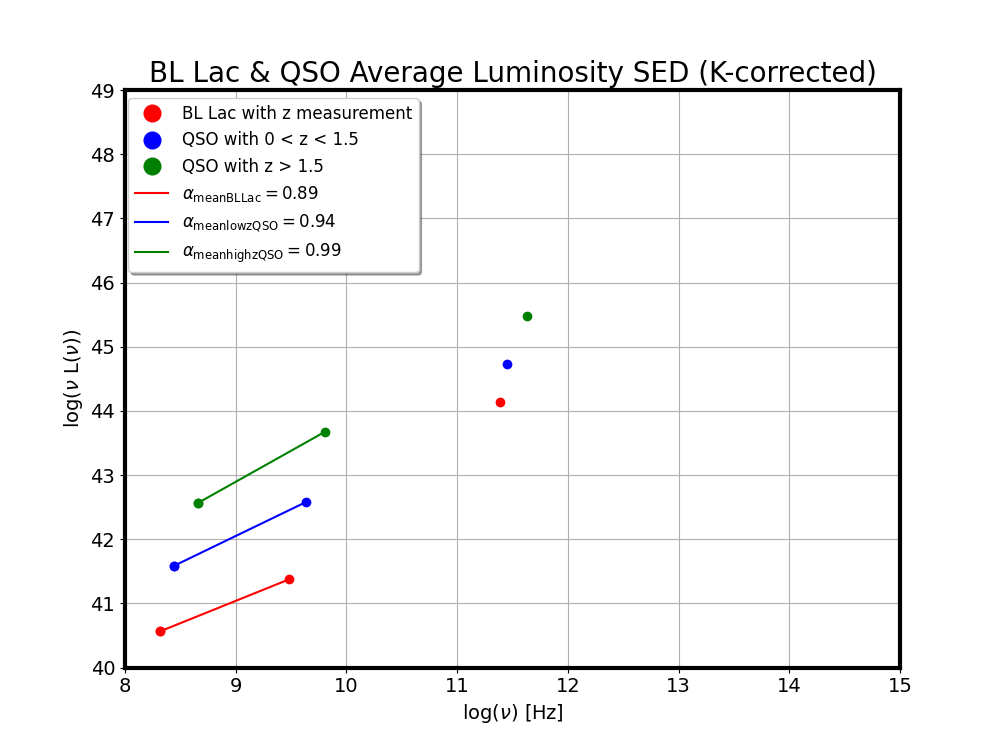

In [9]:
#######################################################################################################
### LUMINOSITY Average SED (Radio + mm/sub-mm ONLY)
#######################################################################################################
# BL Lac
BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind]])
BL_Lac_L = np.hstack([radio_L[BL_Lac_ind]])
BL_Lac_Lerr = np.hstack([radio_Lerr[BL_Lac_ind]])
BL_Lac_Lerr[BL_Lac_Lerr < 0] = np.nan
# low z QSO
lowz_QSO_freq = np.hstack([radio_freq[lowz_QSO_ind]])
lowz_QSO_L = np.hstack([radio_L[lowz_QSO_ind]])
lowz_QSO_Lerr = np.hstack([radio_Lerr[lowz_QSO_ind]])
lowz_QSO_Lerr[lowz_QSO_Lerr < 0] = np.nan
# high z QSO
highz_QSO_freq = np.hstack([radio_freq[highz_QSO_ind]])
highz_QSO_L = np.hstack([radio_L[highz_QSO_ind]])
highz_QSO_L[highz_QSO_L < -30] = np.nan
highz_QSO_Lerr = np.hstack([radio_Lerr[highz_QSO_ind]])
highz_QSO_Lerr[highz_QSO_Lerr < 0] = np.nan

### BL Lac data classifty
BL_Lac_inter = [ min(BL_Lac_freq), 9, 10.5, max(BL_Lac_freq) ]
BL_Lac_group = [None]*(len(BL_Lac_inter)-1)
for i in range(0, len(BL_Lac_inter)-1):
    BL_Lac_group[i] = np.where( (BL_Lac_freq > BL_Lac_inter[i]) & (BL_Lac_freq <= BL_Lac_inter[i+1]) )[0]

# BL Lac average spectral index fitting
BL_lac_midfreq = np.linspace(0, 0, len(BL_Lac_inter)-2)
BL_lac_meanL = np.linspace(0, 0, len(BL_Lac_inter)-2)
for i in range(0, len(BL_Lac_inter)-2):
    BL_lac_midfreq[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanL[i] = np.nanmean(BL_Lac_L[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq, BL_lac_meanL, maxfev = 1000)
BL_Lac_yfit = func(BL_lac_midfreq, *popt)
    
BL_lac_alpha = '%4.2f' % float(popt[0])
    
### low z QSO data classifty
lowz_QSO_inter = [ min(lowz_QSO_freq), 9, 10.5, max(lowz_QSO_freq) ]
lowz_QSO_group = [None]*(len(BL_Lac_inter)-1)
for i in range(0, len(BL_Lac_inter)-1):
    lowz_QSO_group[i] = np.where( (lowz_QSO_freq > lowz_QSO_inter[i]) & (lowz_QSO_freq <= lowz_QSO_inter[i+1]) )[0]
# low z QSO average spectral index fitting
lowz_QSO_midfreq = np.linspace(0, 0, len(BL_Lac_inter)-2)
lowz_QSO_meanL = np.linspace(0, 0, len(BL_Lac_inter)-2)
for i in range(0, len(BL_Lac_inter)-2):
    lowz_QSO_midfreq[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanL[i] = np.nanmean(lowz_QSO_L[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq, lowz_QSO_meanL, maxfev = 1000)
lowz_QSO_yfit = func(lowz_QSO_midfreq, *popt)
    
lowz_QSO_alpha = '%4.2f' % float(popt[0])
    
### high z QSO data classifty
highz_QSO_inter = [ min(highz_QSO_freq), 9, 10.5, max(highz_QSO_freq) ]
highz_QSO_group = [None]*(len(highz_QSO_inter)-1)
for i in range(0, len(highz_QSO_inter)-1):
    highz_QSO_group[i] = np.where( (highz_QSO_freq > highz_QSO_inter[i]) & (highz_QSO_freq <= highz_QSO_inter[i+1]) )[0]
# high z QSO average spectral index fitting
highz_QSO_midfreq = np.linspace(0, 0, len(highz_QSO_inter)-2)
highz_QSO_meanL = np.linspace(0, 0, len(highz_QSO_inter)-2)
for i in range(0, len(highz_QSO_inter)-2):
    highz_QSO_midfreq[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanL[i] = np.nanmean(highz_QSO_L[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq, highz_QSO_meanL, maxfev = 1000)
highz_QSO_yfit = func(highz_QSO_midfreq, *popt)
    
highz_QSO_alpha = '%4.2f' % float(popt[0])
#######################################################################################################

if (plotfigure == 1): 
    plt.rcParams['figure.figsize'] = [10, 7.5]
    plt.rcParams['axes.linewidth'] = 3
    fig, ax = plt.subplots()
    
    ### BL Lac
    ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[0]]), np.nanmean(BL_Lac_L[BL_Lac_group[0]]), 'o', c = 'red', label = 'BL Lac with z measurement') 
    for i in range(0, len(BL_Lac_group)):
        ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_L[BL_Lac_group[i]]), 'o', c = 'red') 
        
        # Luminosity uncertainty error propagation calculation
        err = [0]*len(BL_Lac_L[BL_Lac_group[i]])
        for j in range(0, len(BL_Lac_L[BL_Lac_group[i]])):
            err[j] = uncer.ufloat(BL_Lac_L[BL_Lac_group[i]][j], BL_Lac_Lerr[BL_Lac_group[i]][j]) 
        aa = np.nansum(err)/len(BL_Lac_Lerr[~np.isnan(BL_Lac_Lerr)])
        
        #low_err = [ np.mean(BL_Lac_freq[BL_Lac_group[i]])-BL_Lac_inter[i] ]
        #up_err = [ BL_Lac_inter[i+1]-np.mean(BL_Lac_freq[BL_Lac_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_L[BL_Lac_group[i]]), yerr = aa.s, ecolor = "red", linestyle = '')
        
    ### low z QSO
    ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[0]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[0]]), 'o', c = 'blue', label = 'QSO with 0 < z < 1.5') 
    for i in range(0, len(lowz_QSO_group)):
        ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[i]]), 'o', c = 'blue') 
        
        err = [0]*len(lowz_QSO_L[lowz_QSO_group[i]]) 
        for j in range(0, len(lowz_QSO_L[lowz_QSO_group[i]])):
            err[j] = uncer.ufloat(lowz_QSO_L[lowz_QSO_group[i]][j], lowz_QSO_Lerr[lowz_QSO_group[i]][j]) 
        aa = np.nansum(err)/len(lowz_QSO_Lerr[~np.isnan(lowz_QSO_Lerr)])
        
        #low_err = [ np.mean(lowz_QSO_freq[lowz_QSO_group[i]])-lowz_QSO_inter[i] ]
        #up_err = [ lowz_QSO_inter[i+1]-np.mean(lowz_QSO_freq[lowz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[i]]), yerr = aa.s, ecolor = "blue", linestyle = '')
        
    ### High z QSO
    ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[0]]), np.nanmean(highz_QSO_L[highz_QSO_group[0]]), 'o', c = 'green', label = 'QSO with z > 1.5') 
    for i in range(0, len(highz_QSO_group)):
        ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_L[highz_QSO_group[i]]), 'o', c = 'green') 
        
        err = [0]*len(highz_QSO_L[highz_QSO_group[i]])
        for j in range(0, len(highz_QSO_L[highz_QSO_group[i]])):
            err[j] = uncer.ufloat(highz_QSO_L[highz_QSO_group[i]][j], highz_QSO_Lerr[highz_QSO_group[i]][j]) 
        aa = np.nansum(err)/len(highz_QSO_Lerr[~np.isnan(highz_QSO_Lerr)])
        
        #low_err = [ np.mean(highz_QSO_freq[highz_QSO_group[i]])-highz_QSO_inter[i] ]
        #up_err = [ highz_QSO_inter[i+1]-np.mean(highz_QSO_freq[highz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_L[highz_QSO_group[i]]), yerr = aa.s, ecolor = "green", linestyle = '')
    
    ax.plot(BL_lac_midfreq, BL_Lac_yfit, '-', color = 'red', label = '$\\alpha_\mathrm{mean BL Lac} = $'+ BL_lac_alpha)
    ax.plot(lowz_QSO_midfreq, lowz_QSO_yfit, '-', color = 'blue', label = '$\\alpha_\mathrm{mean lowz QSO} = $'+ lowz_QSO_alpha)
    ax.plot(highz_QSO_midfreq, highz_QSO_yfit, '-', color = 'green', label = '$\\alpha_\mathrm{mean high z QSO} = $'+ highz_QSO_alpha)
    
    ax.grid(True)
    ax.set_xlim (8, 15)
    ax.set_ylim (40, 49)
    fig.legend(loc='upper left', bbox_to_anchor = (0.12, 0.88), shadow=True, fontsize = 12, markerscale = 2) 
            
    plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel('log($\\nu$ L($\\nu$))',  fontsize = 14)
    plt.yticks(fontsize = 14)
            
    plt.title('BL Lac & QSO Average Luminosity SED (K-corrected)', fontsize = 20)

/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/2098710737.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind], IRO_freq[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/2098710737.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind], IRO_freq[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/2098710737.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_Lac_L = np.hstack([radio_L[BL_Lac_ind], IRO_L[BL_Lac_ind]])
/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_18289/2098710737.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  BL_La

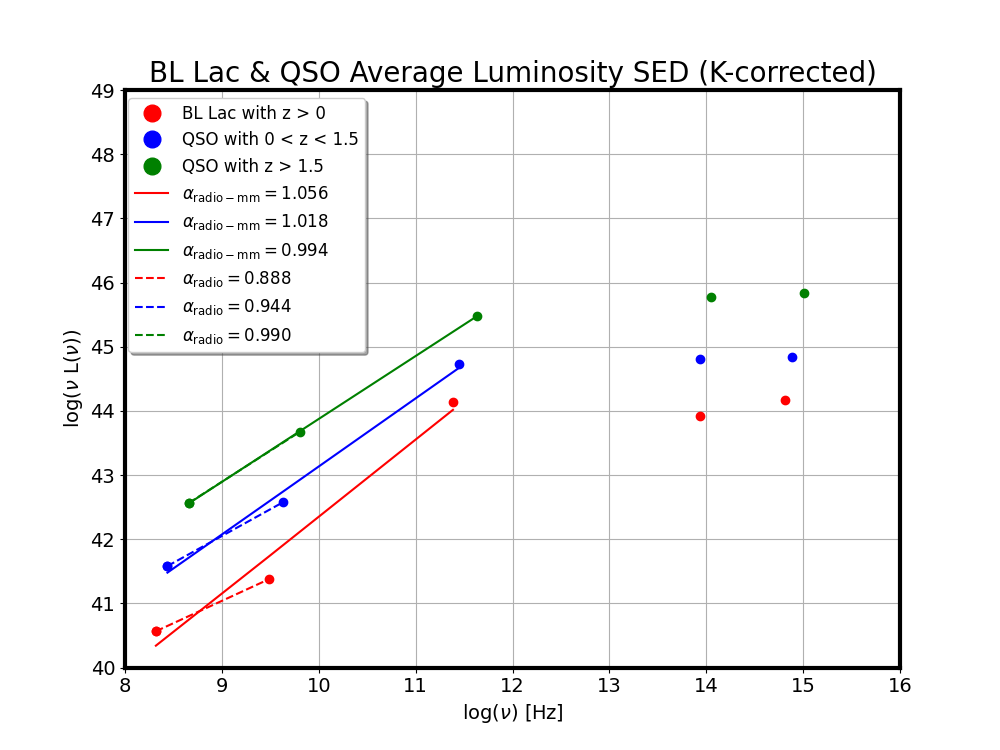

In [10]:
#######################################################################################################
### LUMINOSITY Average SED (Radio + mm/sub-mm + IRO data)
#######################################################################################################
# BL Lac
BL_Lac_freq = np.hstack([radio_freq[BL_Lac_ind], IRO_freq[BL_Lac_ind]])
BL_Lac_L = np.hstack([radio_L[BL_Lac_ind], IRO_L[BL_Lac_ind]])
BL_Lac_Lerr = np.hstack([radio_Lerr[BL_Lac_ind], IRO_Lerr[BL_Lac_ind]])
BL_Lac_Lerr[BL_Lac_Lerr < 0] = np.nan
# low z QSO
lowz_QSO_freq = np.hstack([radio_freq[lowz_QSO_ind], IRO_freq[lowz_QSO_ind]])
lowz_QSO_L = np.hstack([radio_L[lowz_QSO_ind], IRO_L[lowz_QSO_ind]])
lowz_QSO_Lerr = np.hstack([radio_Lerr[lowz_QSO_ind], IRO_Lerr[lowz_QSO_ind]])
lowz_QSO_Lerr[lowz_QSO_Lerr < 0] = np.nan
# high z QSO
highz_QSO_freq = np.hstack([radio_freq[highz_QSO_ind], IRO_freq[highz_QSO_ind]])
highz_QSO_L = np.hstack([radio_L[highz_QSO_ind], IRO_L[highz_QSO_ind]])
highz_QSO_L[highz_QSO_L < -30] = np.nan
highz_QSO_Lerr = np.hstack([radio_Lerr[highz_QSO_ind], IRO_Lerr[highz_QSO_ind]])
highz_QSO_Lerr[highz_QSO_Lerr < 0] = np.nan

### BL Lac data classifty
BL_Lac_inter = [ min(BL_Lac_freq), 9, 10.5, 12.5, 14.5, max(BL_Lac_freq) ]
BL_Lac_group = [None]*(len(BL_Lac_inter)-1)
for i in range(0, len(BL_Lac_inter)-1):
    BL_Lac_group[i] = np.where( (BL_Lac_freq > BL_Lac_inter[i]) & (BL_Lac_freq <= BL_Lac_inter[i+1]) )[0]
    
# BL Lac average radio-mm spectral index fitting
BL_lac_midfreq_radiomm = np.linspace(0, 0, len(BL_Lac_inter)-3)
BL_lac_meanL = np.linspace(0, 0, len(BL_Lac_inter)-3)
for i in range(0, len(BL_Lac_inter)-3):
    BL_lac_midfreq_radiomm[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanL[i] = np.nanmean(BL_Lac_L[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq_radiomm, BL_lac_meanL, maxfev = 1000)
BL_Lac_yfit_radiomm = func(BL_lac_midfreq_radiomm, *popt)
    
BL_lac_alpha_radiomm = '%5.3f' % float(popt[0])

# BL Lac average radio spectral index fitting
BL_lac_midfreq_radio = np.linspace(0, 0, len(BL_Lac_inter)-4)
BL_lac_meanL = np.linspace(0, 0, len(BL_Lac_inter)-4)
for i in range(0, len(BL_Lac_inter)-4):
    BL_lac_midfreq_radio[i] =  np.nanmean(BL_Lac_freq[BL_Lac_group[i]])
    BL_lac_meanL[i] = np.nanmean(BL_Lac_L[BL_Lac_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, BL_lac_midfreq_radio, BL_lac_meanL, maxfev = 1000)
BL_Lac_yfit_radio = func(BL_lac_midfreq_radio, *popt)
    
BL_lac_alpha_radio = '%5.3f' % float(popt[0])
    
### low z QSO data classifty
lowz_QSO_inter = [ min(lowz_QSO_freq), 9, 10.5, 12.5, 14.5, max(lowz_QSO_freq) ]
lowz_QSO_group = [None]*(len(lowz_QSO_inter)-1)
for i in range(0, len(lowz_QSO_inter)-1):
    lowz_QSO_group[i] = np.where( (lowz_QSO_freq > lowz_QSO_inter[i]) & (lowz_QSO_freq <= lowz_QSO_inter[i+1]) )[0]
    
# low z QSO average radio-mm spectral index fitting
lowz_QSO_midfreq_radiomm = np.linspace(0, 0, len(lowz_QSO_inter)-3)
lowz_QSO_meanL = np.linspace(0, 0, len(lowz_QSO_inter)-3)
for i in range(0, len(lowz_QSO_inter)-3):
    lowz_QSO_midfreq_radiomm[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanL[i] = np.nanmean(lowz_QSO_L[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq_radiomm, lowz_QSO_meanL, maxfev = 1000)
lowz_QSO_yfit_radiomm = func(lowz_QSO_midfreq_radiomm, *popt)
    
lowz_QSO_alpha_radiomm = '%5.3f' % float(popt[0])

# low z QSO average radio spectral index fitting
lowz_QSO_midfreq_radio = np.linspace(0, 0, len(BL_Lac_inter)-4)
lowz_QSO_meanL = np.linspace(0, 0, len(BL_Lac_inter)-4)
for i in range(0, len(BL_Lac_inter)-4):
    lowz_QSO_midfreq_radio[i] =  np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]])
    lowz_QSO_meanL[i] = np.nanmean(lowz_QSO_L[lowz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c      
popt, pcov = curve_fit(func, lowz_QSO_midfreq_radio, lowz_QSO_meanL, maxfev = 1000)
lowz_QSO_yfit_radio = func(lowz_QSO_midfreq_radio, *popt)
    
lowz_QSO_alpha_radio = '%5.3f' % float(popt[0])
    
### high z QSO data classifty
highz_QSO_inter = [ min(highz_QSO_freq), 9, 10.5, 12.5, 14.5, max(highz_QSO_freq) ]
highz_QSO_group = [None]*(len(highz_QSO_inter)-1)
for i in range(0, len(highz_QSO_inter)-1):
    highz_QSO_group[i] = np.where( (highz_QSO_freq > highz_QSO_inter[i]) & (highz_QSO_freq <= highz_QSO_inter[i+1]) )[0]
    
# high z QSO average radio-mm spectral index fitting
highz_QSO_midfreq_radiomm = np.linspace(0, 0, len(highz_QSO_inter)-3)
highz_QSO_meanL = np.linspace(0, 0, len(highz_QSO_inter)-3)
for i in range(0, len(highz_QSO_inter)-3):
    highz_QSO_midfreq_radiomm[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanL[i] = np.nanmean(highz_QSO_L[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq_radiomm, highz_QSO_meanL, maxfev = 1000)
highz_QSO_yfit_radiomm = func(highz_QSO_midfreq_radiomm, *popt)
    
highz_QSO_alpha_radiomm = '%5.3f' % float(popt[0])

# high z QSO average spectral index fitting
highz_QSO_midfreq_radio = np.linspace(0, 0, len(highz_QSO_inter)-4)
highz_QSO_meanL = np.linspace(0, 0, len(highz_QSO_inter)-4)
for i in range(0, len(highz_QSO_inter)-4):
    highz_QSO_midfreq_radio[i] =  np.nanmean(highz_QSO_freq[highz_QSO_group[i]])
    highz_QSO_meanL[i] = np.nanmean(highz_QSO_L[highz_QSO_group[i]])
    
def func(x, a, c):
    return x**(a)+c     
popt, pcov = curve_fit(func, highz_QSO_midfreq_radio, highz_QSO_meanL, maxfev = 1000)
highz_QSO_yfit_radio = func(highz_QSO_midfreq_radio, *popt)
    
highz_QSO_alpha_radio = '%5.3f' % float(popt[0])
#######################################################################################################
    
if (plotfigure == 1): 
    plt.rcParams['figure.figsize'] = [10, 7.5]
    plt.rcParams['axes.linewidth'] = 3
    fig, ax = plt.subplots()
    
    ### BL Lac
    ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[0]]), np.nanmean(BL_Lac_L[BL_Lac_group[0]]), 'o', c = 'red', label = 'BL Lac with z > 0') 
    for i in range(0, len(BL_Lac_group)):
        ax.plot(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_L[BL_Lac_group[i]]), 'o', c = 'red') 
        
        # Luminosity uncertainty error propagation calculation
        err = [0]*len(BL_Lac_L[BL_Lac_group[i]])
        for j in range(0, len(BL_Lac_L[BL_Lac_group[i]])):
            err[j] = uncer.ufloat(BL_Lac_L[BL_Lac_group[i]][j], BL_Lac_Lerr[BL_Lac_group[i]][j]) 
        aa = np.nansum(err)/len(BL_Lac_Lerr[~np.isnan(BL_Lac_Lerr)])
        
        #low_err = [ np.mean(BL_Lac_freq[BL_Lac_group[i]])-BL_Lac_inter[i] ]
        #up_err = [ BL_Lac_inter[i+1]-np.mean(BL_Lac_freq[BL_Lac_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(BL_Lac_freq[BL_Lac_group[i]]), np.nanmean(BL_Lac_L[BL_Lac_group[i]]), yerr = aa.s, ecolor = "red", linestyle = '')
        
    ### low z QSO
    ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[0]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[0]]), 'o', c = 'blue', label = 'QSO with 0 < z < 1.5') 
    for i in range(0, len(lowz_QSO_group)):
        ax.plot(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[i]]), 'o', c = 'blue') 
        
        err = [0]*len(lowz_QSO_L[lowz_QSO_group[i]])
        for j in range(0, len(lowz_QSO_L[lowz_QSO_group[i]])):
            err[j] = uncer.ufloat(lowz_QSO_L[lowz_QSO_group[i]][j], lowz_QSO_Lerr[lowz_QSO_group[i]][j]) 
        aa = np.nansum(err)/len(lowz_QSO_Lerr[~np.isnan(lowz_QSO_Lerr)])
        
        #low_err = [ np.mean(lowz_QSO_freq[lowz_QSO_group[i]])-lowz_QSO_inter[i] ]
        #up_err = [ lowz_QSO_inter[i+1]-np.mean(lowz_QSO_freq[lowz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(lowz_QSO_freq[lowz_QSO_group[i]]), np.nanmean(lowz_QSO_L[lowz_QSO_group[i]]), yerr = aa.s, ecolor = "blue", linestyle = '')
        
    ### High z QSO
    ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[0]]), np.nanmean(highz_QSO_L[highz_QSO_group[0]]), 'o', c = 'green', label = 'QSO with z > 1.5') 
    for i in range(0, len(highz_QSO_group)):
        ax.plot(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_L[highz_QSO_group[i]]), 'o', c = 'green') 
        err = [0]*len(highz_QSO_L[highz_QSO_group[i]])
        
        for j in range(0, len(highz_QSO_L[highz_QSO_group[i]]) ):
            err[j] = uncer.ufloat(highz_QSO_L[highz_QSO_group[i]][j], highz_QSO_Lerr[highz_QSO_group[i]][j]) 
            
        #aa = np.nansum(err)/len(highz_QSO_Lerr[~np.isnan(highz_QSO_Lerr)])
        
        #low_err = [ np.mean(highz_QSO_freq[highz_QSO_group[i]])-highz_QSO_inter[i] ]
        #up_err = [ highz_QSO_inter[i+1]-np.mean(highz_QSO_freq[highz_QSO_group[i]]) ]
        #x_err = np.array(list(zip(np.array(low_err) ,np.array(up_err)))).T

        #ax.errorbar(np.nanmean(highz_QSO_freq[highz_QSO_group[i]]), np.nanmean(highz_QSO_L[highz_QSO_group[i]]), yerr = aa.s, ecolor = "green", linestyle = '')
    
    ax.plot(BL_lac_midfreq_radiomm, BL_Lac_yfit_radiomm, '-', color = 'red', label = '$\\alpha_\mathrm{radio-mm} = $'+ BL_lac_alpha_radiomm)
    ax.plot(lowz_QSO_midfreq_radiomm, lowz_QSO_yfit_radiomm, '-', color = 'blue', label = '$\\alpha_\mathrm{radio-mm} = $'+ lowz_QSO_alpha_radiomm)
    ax.plot(highz_QSO_midfreq_radiomm, highz_QSO_yfit_radiomm, '-', color = 'green', label = '$\\alpha_\mathrm{radio-mm} = $'+ highz_QSO_alpha_radiomm)
    ax.plot(BL_lac_midfreq_radio, BL_Lac_yfit_radio, '--', color = 'red', label = '$\\alpha_\mathrm{radio} = $'+ BL_lac_alpha_radio)
    ax.plot(lowz_QSO_midfreq_radio, lowz_QSO_yfit_radio, '--', color = 'blue', label = '$\\alpha_\mathrm{radio} = $'+ lowz_QSO_alpha_radio)
    ax.plot(highz_QSO_midfreq_radio, highz_QSO_yfit_radio, '--', color = 'green', label = '$\\alpha_\mathrm{radio} = $'+ highz_QSO_alpha_radio)
    
    ax.grid(True)
    ax.set_xlim (8, 16)
    ax.set_ylim (40, 49)
    fig.legend(loc='upper left', bbox_to_anchor = (0.12, 0.88), shadow=True, fontsize = 12, markerscale = 2) 
            
    plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.ylabel('log($\\nu$ L($\\nu$))',  fontsize = 14)
    plt.yticks(fontsize = 14)
            
    plt.title('BL Lac & QSO Average Luminosity SED (K-corrected)', fontsize = 20)